# 梯度消失和梯度下降问题 Vanishing/Exploding Gradients Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import font_manager
my_font = font_manager.FontProperties(fname='./Fonts/SourceHanSerifSC-Medium.otf', size=12)

In [3]:
def logit(x):
    return 1/(1+np.exp(-x))

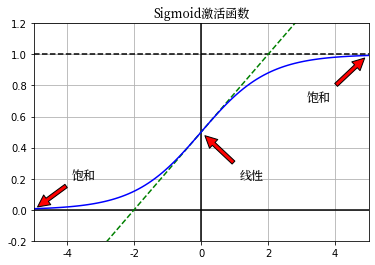

In [4]:
x = np.linspace(-5, 5, 100)

plt.plot([-5,5], [0,0], 'k-')
plt.plot([-5,5], [1,1], 'k--')
plt.plot([0,0], [-0.2,1.2], 'k-')
plt.plot([-5,5], [-3/4, 7/4], 'g--')

plt.plot(x, logit(x), 'b-')

props = dict(facecolor='red', shrink=0.1)   # 箭头的样式
plt.annotate(s='饱和', xy=(5,1), xytext=(3.5, 0.7), font_properties=my_font, arrowprops=props, ha="center")
plt.annotate(s='线性', xy=(0,0.5), xytext=(1.5, 0.2), font_properties=my_font, arrowprops=props, ha="center")
plt.annotate(s='饱和', xy=(-5,0), xytext=(-3.5, 0.2), font_properties=my_font, arrowprops=props, ha="center")

plt.title("Sigmoid激活函数", font_properties=my_font)
plt.axis([-5, 5, -0.2, 1.2])
plt.grid(True)
plt.show()

反向传播算法中，随着算法向下传播到较低层，梯度通常为越来越小。结果梯度下降更新使较低层的连接权重保持不变，训练不能收敛到一个良好的解。我们称其为**梯度消失**。相反，梯度可能越来越大，各层需要更新很大的权重直到算法发散为止，这是**梯度爆炸**问题。

如上图所示，当输入变大时，该函数会以0或1饱和，并且导数接近0。因此反向传播开始时几乎没有梯度可以通过网络传播回去。

## Glorot和He初始化

在Glorot和Bengio的论文中阐述了关于训练DNN时梯度不稳定的一些观点:使用在当时比较流行的`sigmoid激活函数`和`权重初始化技术`，每层输出的方差远大于其输入的方差，随着网络的延伸，方差在每一层之后都会增加，直到激活函数在顶层达到饱和为止。

初始化一个深度网络时,为了缓解梯度消失或爆炸问题,我们尽可能保持每个神经元的输入和输出的方差一致,根据神经元的连接数量来自适应地调整初始化分布的方差,这类方法称为`方差缩放Variance Scaling`

- `Glorot`和`Bengio`提出了一种能显著缓解不稳定梯度问题的方法,根据每层的神经元数量来自动计算初始化参数方差的策略`Glorot初始化`:

    a. 使用Sigmoid激活函数时
>1. 若采用**高斯分布**来随机初始化参数，连接权重 $w^{(𝑙)}$ 可以按 $𝒩(0, \frac{2}{M_{l-1} \  + M_{l}} )$的高斯分布进行初始化. 
2. 若采用区间为[−𝑟, 𝑟] 的**均匀分布**来初始化 $w^{(𝑙)}$，则 𝑟取值为$\sqrt{\frac{6}{M_{l-1} \  + M_{l}}}$ .

    b. 使用Tanh激活函数时
>1. 若采用**高斯分布**来随机初始化参数，连接权重 $w^{(𝑙)}$ 可以按 $𝒩(0, 16×\frac{2}{M_{l-1} \  + M_{l}} )$的高斯分布进行初始化. 
2. 若采用区间为[−𝑟, 𝑟] 的**均匀分布**来初始化 $w^{(𝑙)}$，则 𝑟取值为$4\sqrt{\frac{6}{M_{l-1} \  + M_{l}}}$ .

- `LeCun初始化`是上世纪90年代提出的初始化策略，适用于的激活函数为`SELU`:

>1. 若采用**高斯分布**来随机初始化参数，连接权重 $w^{(𝑙)}$ 可以按 $𝒩(0, \frac{1}{M_{l-1} } )$的高斯分布进行初始化. 
2. 若采用区间为[−𝑟, 𝑟] 的**均匀分布**来初始化 $w^{(𝑙)}$，则 𝑟取值为$\sqrt{\frac{3}{M_{l-1} }}$ .

- `He初始化` 当神经元使用`ReLU`激活函数时,通常有一半的神经元输出为0,因此其分布的方差也近似为使用恒等函数时的一半，因此使用此策略.

>1. 若采用**高斯分布**来随机初始化参数，连接权重 $w^{(𝑙)}$ 可以按 $𝒩(0, \frac{2}{M_{l-1} } )$的高斯分布进行初始化. 
2. 若采用区间为[−𝑟, 𝑟] 的**均匀分布**来初始化 $w^{(𝑙)}$，则 𝑟取值为$\sqrt{\frac{6}{M_{l-1} }}$ .

总结:每种激活函数的初始化参数:( $fan_{avg}=\frac{fan_{in}\ +fan_{out}}{2} \ $ )

|  初始化   | 激活函数  | $𝜎^2$  |
|  :----  | :----  |:----:  |
| Glorot  | None, tanh, logistic, softmax |$\frac{1}{fan_{avg}}$ |
| He  | ReLU 和变体 |$\frac{2}{fan_{in}}$ |
| LeCun  | SELU |$\frac{1}{fan_{in}}$ |

默认情况下`Keras`使用的具有**均匀分布的Glorot初始化**.

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
# 更改为He初始化
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [7]:
# 更改为Variance Scaling初始化
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg',
                                                 distribution="uniform")  # 均匀分布

keras.layers.Dense(10, activation=keras.activations.sigmoid,
                   kernel_initializer=he_avg_init)

## 非饱和激活函数 Nonsaturating Activation Functions

### ReLU

`ReLU`,是目前深度神经网络中经常使用的激活函数.
>$\begin{aligned} \text { ReLU }(x) &= \begin{cases}x & \text { if } x>0 \\ 0 & \text { if } x \leq 0\end{cases} \\ &=\max (0, x) \end{aligned}$

1. `ReLU`相较于`Sigmiod`却具有很好的稀疏性,大约50%的神经元会处于激活状态.
2. 在优化方面,相比于 `Sigmiod`型函数的两端饱和,ReLU函数为**左饱和函数** 且在x>0时导数为1,在一定程度上缓解了神经网络的梯度消失问题,加速梯度下降的收敛速度.

3. `ReLU`函数的输出是非零中心化的,给后一层的神经网络引入偏置偏移会影响梯度下降的效率.
4. `ReLU`神经元在训练时比较容易“死亡”.在训练时,如果参数在一次不恰当的更新后,第一个隐藏层中的某个ReLU神经元在所有的训练数据上都不能被激活,那么这个神经元自身参数的梯度永远都会是 0,在以后的训练过程中永远不能被激活,特别是**在使用较大的学习率**.这种现象称为**死亡ReLU问题**,并且也有可能会发生在其他隐藏层.

- 在实际使用中,为了避免上述情况,有几种`ReLU`的变种也会被广泛使用.

In [8]:
# keras中包含的ReLU及其变体的激活函数
for m in dir(keras.layers):
    if "relu" in m.lower():
        print(m)

LeakyReLU
PReLU
ReLU
ThresholdedReLU


- 使用`ReLU`作为激活函数构建一个具有100层隐藏层的神经网络模型训练`Fashion MNIST`数据集

In [9]:
# 加载数据集
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full),(X_test, y_test) = fashion_mnist.load_data()

In [10]:
# 特征缩放
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
# 创建验证集
X_val, X_train = X_train_full[:5000], X_train_full[5000:]
y_val, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
# 输入标准化
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_stds
X_val_scaled = (X_val - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [12]:
# 使用顺序API创建模型
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, 
                             activation=keras.activations.relu, 
                             # ReLU及其变体的参数初始化策略是He初始化
                             kernel_initializer=keras.initializers.he_normal
                            ))
for layer in range(99):
    model.add(keras.layers.Dense(100,
                                 activation=keras.activations.relu,
                                 kernel_initializer=keras.initializers.he_normal
                                ))
model.add(keras.layers.Dense(10,activation=keras.activations.softmax))

In [13]:
# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [14]:
# 训练模型
model.fit(X_train_scaled, y_train,
          epochs=5,
          validation_data=(X_val_scaled, y_val))

Epoch 1/5
1719/1719 [==============================] - 17s 8ms/step - loss: 1.9790 - sparse_categorical_accuracy: 0.2132 - val_loss: 1.6942 - val_sparse_categorical_accuracy: 0.2934
Epoch 2/5
1719/1719 [==============================] - 13s 8ms/step - loss: 1.3494 - sparse_categorical_accuracy: 0.4151 - val_loss: 1.1763 - val_sparse_categorical_accuracy: 0.5140
Epoch 3/5
1719/1719 [==============================] - 13s 8ms/step - loss: 1.0878 - sparse_categorical_accuracy: 0.5224 - val_loss: 0.9304 - val_sparse_categorical_accuracy: 0.5694
Epoch 4/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.9573 - sparse_categorical_accuracy: 0.5790 - val_loss: 0.8212 - val_sparse_categorical_accuracy: 0.6614
Epoch 5/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.9345 - sparse_categorical_accuracy: 0.6115 - val_loss: 0.8073 - val_sparse_categorical_accuracy: 0.6808


In [15]:
# 评估泛化误差
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 4.2651 - sparse_categorical_accuracy: 0.1704


[4.265134811401367, 0.1703999936580658]

结果很糟糕，出现了梯度消失/爆炸问题.

### Leaky ReLU 

- `带泄露的 ReLU(Leaky ReLU)`:在输入x<0时,保持一个很小的梯度$\gamma$,这样当神经元非激活时也能有一个非零的梯度可以更新参数,避免永远不能被激活
>$\begin{aligned} \text { LeakyReLU }(x) &= \begin{cases}x & \text { if } x>0 \\ \gamma x & \text { if } x \leq 0\end{cases} \\ &=\max (0, x)+\gamma \min (0, x) \end{aligned}$

    1. `Leaky ReLU`要好于严格的`ReLU`
    2. $\gamma=0.2$(大泄露)似乎比$\gamma=0.01$(小泄露)产生更好的性能.

In [16]:
def leaky_relu(x, gamma=0.01):
    return np.maximum(0,x) + gamma*np.minimum(0,x)

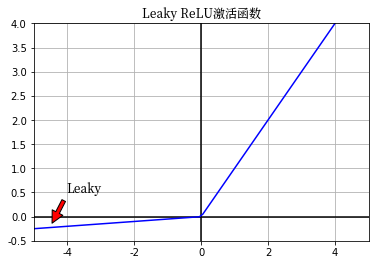

In [17]:
plt.plot([-5,5], [0,0], 'k-')
plt.plot([0,0], [-0.5,4], 'k-')

plt.plot(x, leaky_relu(x, gamma=0.05), 'b-')

props = dict(facecolor='red', shrink=0.1)   # 箭头的样式
plt.annotate(s='Leaky', xy=(-4.5,-0.2), xytext=(-3.5, 0.5), font_properties=my_font, arrowprops=props, ha="center")

plt.title("Leaky ReLU激活函数", font_properties=my_font)
plt.axis([-5, 5, -0.5, 4])
plt.grid(True)
plt.show()

使用`Leaky ReLU`作为激活函数构建神经网络模型训练`Fashion MNIST`数据集

In [18]:
# 使用顺序API创建模型
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    
    # ReLU及其变体的参数初始化策略是He初始化
    keras.layers.Dense(300, kernel_initializer=keras.initializers.he_normal),
    # 创建一个LeakyReLU层
    keras.layers.LeakyReLU(),   
    
    keras.layers.Dense(100, kernel_initializer=keras.initializers.he_normal),
    keras.layers.LeakyReLU(),
    
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [19]:
# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [20]:
# 训练模型
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 1.2819 - sparse_categorical_accuracy: 0.6229 - val_loss: 0.8886 - val_sparse_categorical_accuracy: 0.7160
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7955 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.7130 - val_sparse_categorical_accuracy: 0.7658
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6816 - sparse_categorical_accuracy: 0.7720 - val_loss: 0.6427 - val_sparse_categorical_accuracy: 0.7898
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6217 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.5900 - val_sparse_categorical_accuracy: 0.8064
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5832 - sparse_categorical_accuracy: 0.8074 - val_loss: 0.5582 - val_sparse_categorical_accuracy: 0.8202
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5553 - spars

In [21]:
# 评估泛化误差
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 966us/step - loss: 0.4444 - sparse_categorical_accuracy: 0.8435


[0.44443729519844055, 0.843500018119812]

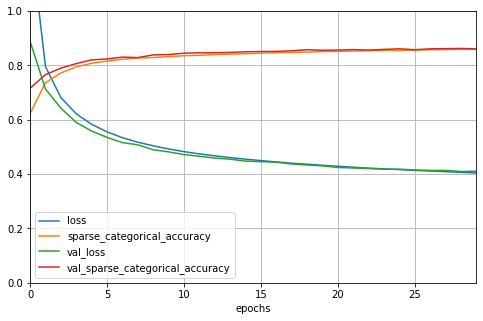

In [22]:
# 绘制学习曲线
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)    # 图例的位置
plt.xlabel('epochs')
plt.show()

- `随机的带泄露的 ReLU(RReLU)`:训练过程中，在给定范围内随机选择$\gamma$；在测试过程中将其固定为平均值.

       keras的RReLU手动实现详见第12章习题

### PReLU

`带参数的 ReLU(Parametric ReLU，PReLU)`引入一个可学习的参数，不同神经元可以有不同的参数.
>$\begin{aligned} \text { PReLU }(x) &= \begin{cases}x & \text { if } x>0 \\ \gamma_i x & \text { if } x \leq 0\end{cases} \\ &=\max (0, x)+\gamma_i \min (0, x) \end{aligned}$

1. `PReLU`在大型图像数据集上的性能明显优于 `ReLU`，但在小的数据集上存在过拟合训练集的风险。
2. $\gamma$可以在训练期间学习

In [23]:
# 使用顺序API创建模型
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    
    keras.layers.Dense(300, kernel_initializer=keras.initializers.he_normal),
    # 创建一个PReLU层
    keras.layers.PReLU(),   
    
    keras.layers.Dense(100, kernel_initializer=keras.initializers.he_normal),
    keras.layers.PReLU(),
    
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=[keras.metrics.sparse_categorical_accuracy])

# 训练模型
history = model.fit(X_train, y_train,
                    epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 4s 2ms/step - loss: 1.3337 - sparse_categorical_accuracy: 0.6140 - val_loss: 0.8951 - val_sparse_categorical_accuracy: 0.7194
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8048 - sparse_categorical_accuracy: 0.7413 - val_loss: 0.7103 - val_sparse_categorical_accuracy: 0.7742
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6849 - sparse_categorical_accuracy: 0.7771 - val_loss: 0.6404 - val_sparse_categorical_accuracy: 0.7960
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.7942 - val_loss: 0.5859 - val_sparse_categorical_accuracy: 0.8126
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5846 - sparse_categorical_accuracy: 0.8073 - val_loss: 0.5542 - val_sparse_categorical_accuracy: 0.8190
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5567 - spars

In [24]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 995us/step - loss: 0.4374 - sparse_categorical_accuracy: 0.8454


[0.437404602766037, 0.8453999757766724]

### ELU

 `ELU(Exponential Linear Unit)`是一个近似的零中心化的非线性函数.
>$\begin{aligned} \text { ELU }(x) &= \begin{cases}x & \text { if } x>0 \\ \gamma (e^x-1) & \text { if } x \leq 0\end{cases} \\ &=\max (0, x)+ \min (0, \gamma (e^x-1)) \end{aligned}$

1. 当$x<0$时,取负值使得该单元的平均输出接近于0，有助于缓解梯度消失问题。
2. $\gamma$是当$x$为较大负数时,`ELU`逼近的值,通常为1.可以在训练期间学习,当$\gamma=1$时，该函数所在位置都是平滑的，有助于加速梯度下降。
3. 缺点是比`ReLU`及其变体函数要慢。

In [25]:
def elu(x, gamma=1):
    return np.maximum(0,x) + np.minimum(0,gamma*(np.exp(x)-1))

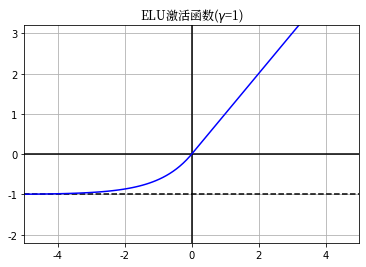

In [26]:
plt.plot([-5,5], [0,0], 'k-')
plt.plot([0,0], [-2.2,3.2], 'k-')
plt.plot([-5,5], [-1,-1], 'k--')

plt.plot(x, elu(x), 'b-')

plt.title("ELU激活函数($\gamma$=1)", font_properties=my_font)
plt.axis([-5, 5, -2.2, 3.2])
plt.grid(True)
plt.show()

`keras`上实现`ELU`激活函数:

In [27]:
keras.layers.Dense(10, activation=keras.activations.elu)

### SELU

 `可拓展的ELU(Scaled ELU,SELU)`是`ELU`的可拓展变体.经过该激活函数后使得样本分布自动归一化到0均值和单位方差1,从而解决梯度消失/爆炸问题。
>$\begin{aligned} \text { SELU }(x) &= \lambda \begin{cases}x & \text { if } x>0 \\ \alpha (e^x-1) & \text { if } x \leq 0\end{cases} \\ &=\lambda (\max (0, x)+ \min (0, \alpha (e^x-1)) \end{aligned}$
   

产生自归一化的条件:
1. 输入特征必须是标准化的(**均值为0和标准差为1**)
2. 每个隐藏层的权重必须`LeCun`正态初始化
3. 网络架构必须是顺序的

In [28]:
# expressions for mean zero and unit variance
from scipy.special import erfc
myAlpha = -np.sqrt(2/np.pi) / (np.exp(0.5) * erfc(1/np.sqrt(2))-1 )  
myLambda = (1-np.sqrt(np.exp(1))*erfc(1/np.sqrt(2)))  *  \
            np.sqrt( 2*np.pi/ (2 + np.pi -2*np.sqrt(np.exp(1))*(2+np.pi)*erfc(1/np.sqrt(2)) + \
            np.exp(1)*np.pi*erfc(1/np.sqrt(2))**2 + 2*np.exp(2)*erfc(np.sqrt(2))))

In [29]:
print("SELU的α参数: ", myAlpha)
print("SELU的λ参数: ", myLambda)

SELU的α参数:  1.6732632423543778
SELU的λ参数:  1.0507009873554807


参考:https://www.jianshu.com/p/d216645251ce

In [30]:
def selu(x, scale=myLambda, alpha=myAlpha):
    return scale*elu(x, alpha)

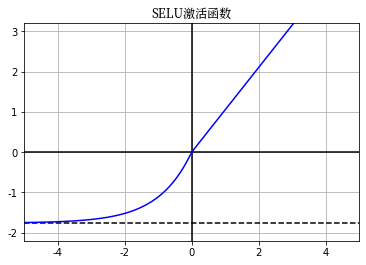

In [31]:
plt.plot([-5,5], [0,0], 'k-')
plt.plot([0,0], [-2.2,3.2], 'k-')
plt.plot([-5,5], [-1.758, -1.758], 'k--')

plt.plot(x, selu(x), 'b-')

plt.title("SELU激活函数", font_properties=my_font)
plt.axis([-5, 5, -2.2, 3.2])
plt.grid(True)
plt.show()

- 默认情况下，SELU超参数（`scale`和`alpha`）的调整方式使每个神经元的输出`mean`保持接近0，`std`保持接近1。使用此激活函数，即使是1000层深度的神经网络也能在所有层上保留大致的`mean`为0和`std`为1，从而避免了梯度爆炸/消失问题

> 1. `LeCun`初始化:若采用**高斯分布**来随机初始化参数，连接权重 $w^{(𝑙)}$ 可以按 $𝒩(0, \frac{1}{M_{l-1} } )$的高斯分布进行初始化. 
2. `np.random.normal()`正态分布:
    1. 参数`loc`：正态分布的均值，对应着这个分布的中心。loc=0说明这一个以Y轴为对称轴的正态分布;
    2. 参数`scale`：正态分布的**标准差**,输入方差要开方。

In [32]:
np.random.seed(42)
X = np.random.normal(size=(500,100))    # 标准化输入
for layer in range(1001):
    W = np.random.normal(size=(100,100), scale=np.sqrt(1/100))   # LeCun标准化
    X = selu(np.dot(X, W))
    
    means = np.mean(X, axis=0).mean()
    stds = np.std(X, axis=0).mean()
    
    if layer%100 == 0:
        print("第{}层:均值{:.2f},标准差{:.2f}".format(layer, means, stds))
    

第0层:均值-0.00,标准差1.00
第100层:均值0.02,标准差0.96
第200层:均值0.01,标准差0.90
第300层:均值-0.02,标准差0.92
第400层:均值0.05,标准差0.89
第500层:均值0.01,标准差0.93
第600层:均值0.02,标准差0.92
第700层:均值-0.02,标准差0.90
第800层:均值0.05,标准差0.83
第900层:均值0.02,标准差1.00
第1000层:均值-0.01,标准差0.92


使用`SELU`作为激活函数构建一个具有100层隐藏层的神经网络模型训练`Fashion MNIST`数据集

In [33]:
# 使用顺序API创建模型
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, 
                             activation=keras.activations.selu, 
                             kernel_initializer=keras.initializers.lecun_normal))
for layer in range(99):
    model.add(keras.layers.Dense(100,                        
                                 activation=keras.activations.selu, 
                                 kernel_initializer=keras.initializers.lecun_normal))
model.add(keras.layers.Dense(10, activation=keras.activations.softmax))
    
# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [34]:
# 训练模型
history = model.fit(X_train_scaled, y_train,
                    epochs=5,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/5
1719/1719 [==============================] - 18s 9ms/step - loss: 1.5496 - sparse_categorical_accuracy: 0.3760 - val_loss: 0.9996 - val_sparse_categorical_accuracy: 0.5720
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.0710 - sparse_categorical_accuracy: 0.5845 - val_loss: 1.3253 - val_sparse_categorical_accuracy: 0.4402
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 1.1057 - sparse_categorical_accuracy: 0.5513 - val_loss: 0.8809 - val_sparse_categorical_accuracy: 0.6884
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.7796 - sparse_categorical_accuracy: 0.7156 - val_loss: 0.6716 - val_sparse_categorical_accuracy: 0.7630
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.6828 - sparse_categorical_accuracy: 0.7472 - val_loss: 0.6354 - val_sparse_categorical_accuracy: 0.7688


In [35]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.0151 - sparse_categorical_accuracy: 0.4113


[2.0150856971740723, 0.41130000352859497]

- 对激活函数选择的取舍:通常**SELU > ELU > leaky ReLU (及其变体) > ReLU > tanh > logistic**
- 如果架构不能自归一化,则**ELU>SELU**
- 如果关系运行延迟,**leaky ReLU**更优
- 如果关系运行速度,**ReLU**仍然是最佳选择,因为**ReLU**是最常用的激活函数,很多库和硬件加速器都提供了对其特定的优化,

## 批量归一化 Batch Normalization

`1.2.1 ReLU`例子中，尽管使用`he初始化`和`Relu`等激活函数，仍然不能保证梯度消失和梯度下降问题在训练期间不会出现.

`批量归一化(Batch Normalization,BN)`方法是一种有效的逐层归一化方法,可以对神经网络中任意的中间层进行归一化操作.
1. 该操作是对每个输入**零中心化并归一化**;为了使得归一化不对网络的表示能力造成负面影响,可以通过一个附加的**缩放和平移变换**改变取值区间.
2. 批量归一化操作可以看作一个特殊的神经层,加在每一层非线性激活函数前
3. `BN层`添加为第一层的话，通常不许进行归一化训练集

> **批量归一化算法**:
给定一个包含 $K$ 个样本的小批量样本集合, 第 $l$ 层神经元的净输入 $\boldsymbol{z}^{(1, l)}$, $\cdots, \boldsymbol{z}^{(K, l)}$ 的均值和方差为
$$
\begin{aligned}
&\mu_{\mathcal{B}}=\frac{1}{K} \sum_{k=1}^{K} z^{(k, l)} \\
&\sigma_{\mathcal{B}}^{2}=\frac{1}{K} \sum_{k=1}^{K}\left(\boldsymbol{z}^{(k, l)}-\boldsymbol{\mu}_{\mathcal{B}}\right) \odot\left(\boldsymbol{z}^{(k, l)}-\mu_{\mathcal{B}}\right)
\end{aligned}
$$
对净输入 $\boldsymbol{z}^{(l)}$ 的标准归一化会使得其取值集中到 0 附近, 如果使用 Sigmoid 型激活函数时, 这个取值区间刚好是接近线性变换的区间, 减弱了神经网络的非线性性质. 因此, 为了使得归一化不对网络的表示能力造成负面影响, 可以通过 一个附加的缩放和平移变换改变取值区间.
$$
\begin{aligned}
\hat{{z}}^{(l)} &=\frac{\boldsymbol{z}^{(l)}-\boldsymbol{\mu}_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^{2}+\epsilon}} \odot \gamma+\boldsymbol{\beta} \\
& \triangleq \mathrm{B} \mathrm{N}_{\gamma, \beta}\left(\boldsymbol{z}^{(l)}\right)
\end{aligned}
$$
其中 $\gamma$ 和 $\boldsymbol{\beta}$ 分别代表缩放和平移的参数向量. 
批量归一化操作可以看作一个特殊的神经层, 加在每一层非线性激活函数 之前。
$$
\boldsymbol{a}^{(l)}=f\left(\mathrm{BN}_{\gamma, \beta}\left(\boldsymbol{z}^{(l)}\right)\right)=f\left(\mathrm{BN}_{\gamma, \beta}\left(\boldsymbol{W} \boldsymbol{a}^{(l-1)}\right)\right)
$$

4. 当训练完成时, 用 整个数据集上的均值 $\mu$ 和方差 $\sigma$ 来分别代替每次小批量样本的 $\mu_{\mathcal{B}}$ 和方差 $\sigma_{\mathcal{B}}^{2}$. 在实践中, $\mu_{\mathcal{B}}$ 和 $\sigma_{\mathcal{B}}^{2}$ 也可以用**移动平均**来计算.
5.  $\mu_{\mathcal{B}}$ 和 $\sigma_{\mathcal{B}}^{2}$ 计算实例:
<img src="./images/other/14-39.png">
5. 因为批量归一化本身具有平移变换,所以仿射变换${W} {a}^{(l-1)}$不再需要偏置参数.
6. 综上，每个批归一化层学习四个参数向量:
    - 常规反向传播学习:$\gamma$(输出缩放向量),$\beta$(输出偏移向量)
    - 指数平均移动估计:$\mu$(最终输出均值向量),$\sigma$(最终输出标准差向量)
7. 逐层归一化不但可以提高优化效率,还可以作为一种隐形的**正则化方法**. 在训练时, 神经网络对一个样本的预测不仅和该样本自身相关, 也和同一批次中的其他样本相关. 由于在选取批次时具有随机性, 因此使得神经网 络不会“过拟合”到某个特定样本, 从而提高网络的泛化能力.
8. 通过将训练后的`BN层`与上一层融合，从而避免了运行时的损失
10. 训练时要将`traning`参数设置为True，在验证时将`trainning`参数设置为False
11. `batch_size`尽可能设置大点，设置小后表现可能很糟糕，设置的越大求的均值和方差越接近整个训练集的均值和方差。

- 用`keras`实现`批量归一化`(在隐藏层之后应用`BN层`)

In [36]:
# 使用顺序API创建模型
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    # 添加BN层
    keras.layers.BatchNormalization(),
    
    # 注意:这里是在隐藏层之后应用BN层
    keras.layers.Dense(300, activation=keras.activations.elu, 
                       kernel_initializer=keras.initializers.he_normal),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(100, activation=keras.activations.elu, 
                       kernel_initializer=keras.initializers.he_normal),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_211 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_212 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_213 (Dense)            (None, 10)               

In [38]:
# 查看第一个BN层的参数
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

12. $\mu$,$\sigma$是平均移动值，一次是不可训练的，即不受反向传播影响.`keras`创建`BN层`时,会创建两个更新平均移动值的操作.

In [39]:
# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=[keras.metrics.sparse_categorical_accuracy])

# 训练模型
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9160 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.6112 - val_sparse_categorical_accuracy: 0.7906
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6098 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.5257 - val_sparse_categorical_accuracy: 0.8188
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5532 - sparse_categorical_accuracy: 0.8070 - val_loss: 0.4875 - val_sparse_categorical_accuracy: 0.8338
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5147 - sparse_categorical_accuracy: 0.8216 - val_loss: 0.4638 - val_sparse_categorical_accuracy: 0.8418
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4927 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.4465 - val_sparse_categorical_accuracy: 0.8486
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4758 - spars

13. 论文作者主张在激活函数之前添加`BN层`,这一点存在争议,依据问题的实际情况进行实验.

    - 以下是在激活函数之前添加`BN层`,并删除上一层偏置参数的示例.

In [40]:
# 使用顺序API创建模型
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(300, use_bias=False,  # 删除偏置项
                       kernel_initializer=keras.initializers.he_normal),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.elu),
    
    keras.layers.Dense(100, use_bias=False,  
                       kernel_initializer=keras.initializers.he_normal),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.elu),
    
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [41]:
# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=[keras.metrics.sparse_categorical_accuracy])

# 训练模型
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_val, y_val))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9432 - sparse_categorical_accuracy: 0.6886 - val_loss: 0.6353 - val_sparse_categorical_accuracy: 0.7918
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6323 - sparse_categorical_accuracy: 0.7863 - val_loss: 0.5443 - val_sparse_categorical_accuracy: 0.8166
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5707 - sparse_categorical_accuracy: 0.8039 - val_loss: 0.5048 - val_sparse_categorical_accuracy: 0.8326
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5339 - sparse_categorical_accuracy: 0.8164 - val_loss: 0.4796 - val_sparse_categorical_accuracy: 0.8400
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5097 - sparse_categorical_accuracy: 0.8233 - val_loss: 0.4626 - val_sparse_categorical_accuracy: 0.8450
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4940 - spars

14.  `BatchNormalization()`的超参数
    - `omentum`:更新指数移动平均值时用到的超参.
    
        给定一个新值$v$(该批次的输入均值或标准差).
    
        更新运行时的平均$\hat{v}$为:
    $$
    \hat{v} \leftarrow  \hat{v}×momentum+v×(1-momentum)
    $$
    𝑚𝑜𝑚𝑒𝑛𝑡𝑢𝑚通常接近于1.
    
    - `axis`:确定那个轴应该被归一化.
    默认为-1,即最后一个轴进行归一化.

## 梯度裁剪 Gradient Clipping

`梯度裁剪`是解决梯度爆炸的一种技术，其出发点是非常简明的：如果梯度变得非常大，那么我们就调节它使其保持较小的状态，使它们永远不会超过某个阈值.最常用于`循环神经网络RNN`.

参考:https://blog.csdn.net/qq_34769162/article/details/111171116

所有Keras优化器都接受`clipnorm`或`clipvalue`参数

`clipvalue`优化器会将梯度向量的每个分量都裁切为-1.0~1.0之间的值。

In [42]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss=keras.losses.mse,
              optimizer=optimizer)

要确保梯度裁剪不更改梯度向量的方向,通过设置`clipnorm`而不是`clipvalue`来实现

In [43]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss=keras.losses.mse,
              optimizer=optimizer)

# 重用预训练层 Reusing Pretrained Layers

对于训练非常大型的DNN,我们通常可以找到一个任务类似的神经网络,然后重用该网络的较低层.这被称为`迁移学习`.它会大大加快训练速度,而且会大大减少训练数据.

<img src="./images/other/11-1.png" width="400">

1. 如果新任务的输入图片与原始任务中使用的图片不同,通常需要添加预处理步骤使得其调整为原始模型所需的大小.
2. 通常需要替换掉原始模型的输出层;需要找到正确的层数来重用,任务越相似,可重用的层越多.

## 用Keras进行迁移学习 Reusing a Keras model

将`fashion MNIST`训练集分成两部分：
- `X_train_A`：除凉鞋和衬衫外的所有物品的所有图像.
- `X_train_B`：相对小得多的训练集，只包含前200张凉鞋或衬衫的图片.

验证集和测试集也以这种方式分割，但不限制图像的数量。

我们将在`model_A`（包含8个类的分类任务）上训练一个模型，并尝试重用它来处理`model_B`（二元分类器）。

我们希望实现`迁移学习`，因为`model_A`的标签（运动鞋、踝靴、外套、t恤等）与`model_B`的标签（凉鞋和衬衫）有些相似。然而，由于我们使用的是`Dense层`，只有发生在同一位置的模式才能被重用（相比之下，卷积层的传输会更好，因为学习的模式可以在图像的任何地方被检测到）.

In [44]:
tf.random.set_seed(42)
np.random.seed(42)

1. 分割数据集

In [45]:
def split_dataset(X, y):
    y_5_6 = (y==5) | (y==6)   # 5或6
    y_A = y[~y_5_6]           # ~取反
    y_A[y_A>6] -= 2           # 将标签 7,8,9 挪至 5,6,7
    
    y_B = (y[y_5_6] == 6).astype(np.float32)     # 凉鞋或衬衫图像中对衬衫进行二分类
    
    return (X[~y_5_6], y_A), (X[y_5_6], y_B)

In [46]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_val_A, y_val_A), (X_val_B, y_val_B) = split_dataset(X_val, y_val)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)

In [47]:
# X_train_B只包含前200张凉鞋或衬衫的图片
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [48]:
X_train_A.shape, X_train_B.shape

((43986, 28, 28), (200, 28, 28))

In [49]:
y_train_A[:10]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4], dtype=uint8)

In [50]:
y_train_B[:10]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0.], dtype=float32)

2. 构建模型A

In [51]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden,
                                   activation=keras.activations.selu,
                                   kernel_initializer=keras.initializers.lecun_normal
                                  ))
model_A.add(keras.layers.Dense(8, activation=keras.activations.softmax))

In [52]:
# 使用交叉熵损失函数
model_A.compile(loss=keras.losses.sparse_categorical_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=[keras.metrics.sparse_categorical_accuracy])

In [53]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_val_A, y_val_A))

Epoch 1/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.6196 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.3944 - val_sparse_categorical_accuracy: 0.8672
Epoch 2/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3599 - sparse_categorical_accuracy: 0.8776 - val_loss: 0.3260 - val_sparse_categorical_accuracy: 0.8899
Epoch 3/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.3193 - sparse_categorical_accuracy: 0.8887 - val_loss: 0.2982 - val_sparse_categorical_accuracy: 0.8981
Epoch 4/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2992 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.2862 - val_sparse_categorical_accuracy: 0.9023
Epoch 5/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2858 - sparse_categorical_accuracy: 0.9015 - val_loss: 0.2752 - val_sparse_categorical_accuracy: 0.9058
Epoch 6/20
1375/1375 [==============================] - 3s 2ms/step - loss: 0.2759 - spars

In [54]:
# 保存模型A
model_A.save("model_A.h5")

3. 构建模型B

In [55]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden,
                                   activation=keras.activations.selu,
                                   kernel_initializer=keras.initializers.lecun_normal
                                  ))
model_B.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))

In [56]:
# 使用二值交叉熵
model_B.compile(loss=keras.losses.binary_crossentropy,
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=[keras.metrics.binary_accuracy])

In [57]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_val_B, y_val_B))

Epoch 1/20
7/7 [==============================] - 1s 31ms/step - loss: 0.8029 - binary_accuracy: 0.4850 - val_loss: 0.5978 - val_binary_accuracy: 0.7150
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5331 - binary_accuracy: 0.7650 - val_loss: 0.4803 - val_binary_accuracy: 0.8174
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.4282 - binary_accuracy: 0.8650 - val_loss: 0.3992 - val_binary_accuracy: 0.8986
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3544 - binary_accuracy: 0.9300 - val_loss: 0.3409 - val_binary_accuracy: 0.9280
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.3006 - binary_accuracy: 0.9550 - val_loss: 0.2971 - val_binary_accuracy: 0.9432
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2596 - binary_accuracy: 0.9600 - val_loss: 0.2641 - val_binary_accuracy: 0.9574
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.2292 - binar

In [58]:
model_B.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_223 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_224 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_225 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_226 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_227 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_228 (Dense)            (None, 1)                

4. 加载模型A并基于该模型创建一个新模型

- 由于`model_A `与`model_B_on_A`存在共用层,训练过程会相互影响.因此需要在重用`model_A`前进行克隆.

In [59]:
model_A = keras.models.load_model("model_A.h5")
model_A_clone = keras.models.clone_model(model_A)
# 还需要复制其权重
model_A_clone.set_weights(model_A.get_weights())

- 重用除输出层以外的所有层

In [60]:
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])   
model_B_on_A.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))

5. 冻结重用层

    - 在前几个轮次时冻结重用层,给新层一些时间来学习.原因是新的输出层是随机初始化的,存在较大的错误,这会破坏重用的权重.

In [61]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

In [62]:
model_B_on_A.summary()   # 不可训练的参数: 275,801 - 51 =275,750

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_217 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_218 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_219 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_220 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_221 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

- 冻结或解冻层之后,总是需要编译模型

In [63]:
model_B_on_A.compile(loss=keras.losses.binary_crossentropy,
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=[keras.metrics.binary_accuracy])

In [64]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_val_B, y_val_B))

Epoch 1/4
7/7 [==============================] - 1s 30ms/step - loss: 0.3917 - binary_accuracy: 0.9150 - val_loss: 0.3706 - val_binary_accuracy: 0.9239
Epoch 2/4
7/7 [==============================] - 0s 8ms/step - loss: 0.3734 - binary_accuracy: 0.9200 - val_loss: 0.3544 - val_binary_accuracy: 0.9341
Epoch 3/4
7/7 [==============================] - 0s 9ms/step - loss: 0.3566 - binary_accuracy: 0.9250 - val_loss: 0.3396 - val_binary_accuracy: 0.9442
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.3413 - binary_accuracy: 0.9400 - val_loss: 0.3261 - val_binary_accuracy: 0.9544


6. 尝试解冻重用层
   
     - 可以尝试解冻上隐藏层的一两层,使反向传播对其进行调整,查看性能是否得到提高.拥有的训练数据越多,可以解冻的层越多.
     - 解冻重用层时,应降低学习率,避免破坏已经调整好的权重.

In [65]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

In [66]:
model_B_on_A.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_217 (Dense)            (None, 300)               235500    
_________________________________________________________________
dense_218 (Dense)            (None, 100)               30100     
_________________________________________________________________
dense_219 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_220 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_221 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_229 (Dense)            (None, 1)                

In [67]:
model_B_on_A.compile(loss=keras.losses.binary_crossentropy,
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),   # 降低学习率 默认1e-2
                     metrics=[keras.metrics.binary_accuracy])

In [68]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_val_B, y_val_B))

Epoch 1/16
7/7 [==============================] - 1s 31ms/step - loss: 0.3085 - binary_accuracy: 0.9600 - val_loss: 0.2709 - val_binary_accuracy: 0.9696
Epoch 2/16
7/7 [==============================] - 0s 9ms/step - loss: 0.2557 - binary_accuracy: 0.9850 - val_loss: 0.2310 - val_binary_accuracy: 0.9817
Epoch 3/16
7/7 [==============================] - 0s 9ms/step - loss: 0.2174 - binary_accuracy: 0.9850 - val_loss: 0.2013 - val_binary_accuracy: 0.9899
Epoch 4/16
7/7 [==============================] - 0s 9ms/step - loss: 0.1886 - binary_accuracy: 0.9950 - val_loss: 0.1788 - val_binary_accuracy: 0.9899
Epoch 5/16
7/7 [==============================] - 0s 9ms/step - loss: 0.1665 - binary_accuracy: 0.9950 - val_loss: 0.1605 - val_binary_accuracy: 0.9919
Epoch 6/16
7/7 [==============================] - 0s 9ms/step - loss: 0.1482 - binary_accuracy: 0.9950 - val_loss: 0.1458 - val_binary_accuracy: 0.9929
Epoch 7/16
7/7 [==============================] - 0s 9ms/step - loss: 0.1336 - binary_a

7. 对比模型性能

In [69]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1062 - binary_accuracy: 0.9835


[0.10621337592601776, 0.9835000038146973]

In [70]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 981us/step - loss: 0.0776 - binary_accuracy: 0.9965


[0.0775698870420456, 0.9965000152587891]

In [71]:
(100 - 98.35) / (100 - 99.65)

4.714285714285807

使用迁移学习,错误率得到了显著的下降.但事实证明,迁移学习在小型密集型网络中不能很好的工作,迁移学习适合使用深层卷积神经网络,该神经网络倾向于学习更为通用的特征检测器(尤其是在较低层).

## 无监督预训练 Unsupervised Pretraining

<img src="./images/other/11-2.png" width="400">

在无监督训练中,便用一个无监督学习技术对无标记数据(或所有数据)进行训练 然后使用一个有监督学习技术对有标记数据进行最后任务的微调,无监督部分可以一次训练层(`RBM`),如图所示,也可以直接训练整个模型(直接第3步开始)(`GAN`)。

## 辅助任务的预训练 Pretraining on an Auxiliary Task

如果你没有太多标记的训练数据,最后一个选择是在辅助任务上训练第一个神经网络,你可以轻松地为其获得或生成标记的训练数据,然后对实际任务重用该网络的较低层,**第一个神经网络的较低层将学习特征检测器**,**第二个神经网络可能会重用这些特征检测器**。

例如,如果你要构建一个识别人脸的系统,毎个人可能只有几张照片,显然不足以训练一个好的分类器。收集毎个人的数百张图片不切实际。但是,你可以在网络上收集很多随机人物的图片,然后训练第一个神经网络来检测两个不同的图片是否是同一个人。这样的网络将会学习到很好的人脸特征检测器,因此重用其较低层可以使你用很少的训练数据来训练一个好的人脸分类器.

# 更快的优化器 Faster Optimizers

## 梯度估计修正 

在随机(小批量)梯度下降法中,如果每次选取样本数量比较小,损失会呈现振荡的方式下降.也就是说,随机梯度下降方法中每次迭代的梯度估计和整个训练集上的最优梯度并不一致,具有一定的随机性.

一种有效地缓解梯度估计随机性的方式是通过使用最近一段时间内的平均梯度来代替当前时刻的随机梯度来作为参数更新的方向,从而提高优化速度.

###  动能优化 Momentum Optimization

`动量(Momentum)`是模拟物理中的概念.一个物体的动量指的是该物体在它运动方向上保持运动的趋势,是该物体的质量和速度的乘积.`动量法`是用之前积累动量来替代真正的梯度.每次迭代的梯度可以看作**加速度**.

>在第 $t$ 次迭代时,计算负梯度的“加权移动平均”作为参数的更新方向,
$$
\Delta \theta_{t}=\rho \Delta \theta_{t-1}-\alpha \mathbf{g}_{t}
$$
其中 $\rho$ 为动量因子,通常设为 $0.9, \alpha$ 为学习率.

这样, 每个参数的实际更新差值取决于最近一段时间内梯度的加权平均值.

<img src="./images/other/11-5.png" width="450">

- 一般而言, 在迭代初期, 梯度方向都比较一致, 动量法会起到加速作用,可以更快地到达最优点.
- 在迭代后期,梯度方向会不一致,在收敛值附近振荡,动量法会起到减速作用,增加稳定性.
- 在不使用批量归一化的深层神经网络中,较高的层通常会得到比例不同的输入,使用动能优化会有所帮助,还能绕过局部最优问题.

In [72]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

### Nesterov 加速梯度  Nesterov Accelerated Gradient

`Nesterov 加速梯度`是对在`动量法`的改进.动量法中, 实际的参数更新方向 $\Delta \theta_{t}$ 为上一步的参数更新方向 $\Delta \theta_{t-1}$ 和当前梯度的反方向 $-\mathbf{g}_{t}$ 的叠加. 这样, $\Delta \theta_{t}$ 可以被拆分为两步进行, 先根据 $\Delta \theta_{t-1}$ 更新一次得到参数 $\hat{\theta}$,再用 $-\mathrm{g}_{t}$ 进行更新.
>$$
\begin{aligned}
\hat{\theta} &=\theta_{t-1}+\rho \Delta \theta_{t-1} \\
\theta_{t} &=\hat{\theta}-\alpha \mathbf{g}_{t}
\end{aligned}
$$
其中梯度 $\mathbf{g}_{t}$ 为点 $\theta_{t-1}$ 上的梯度, 因此在第二步更新中有些不太合理. 更合理的更新方向应该为 $\hat{\theta}$ 上的梯度.
这样,合并后的更新方向为
$$
\Delta \theta_{t}=\theta_{t}-\theta_{t-1}=\rho \Delta \theta_{t-1}-\alpha \mathfrak{g}_{t}\left(\theta_{t-1}+\rho \Delta \theta_{t-1}\right)
$$

其核心思想会利用 “下一步的梯度” 确定 “这一步的梯度”，当然这里 “下一步的梯度” 并非真正的下一步的梯度，而是指仅根据动量项更新后位置的梯度。`NAG`通常比常规动能优化更快.

<img src="./images/other/11-4.png" width="450">

In [73]:
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9,
                                 nesterov=True)

## 自适应调整学习率

在标准的梯度下降法中,每个参数在每次迭代时都使用相同的学习率.由于每个参数的维度上收敛速度都不相同,因此根据不同参数的收敛情况分别设置学习率.

### AdaGrad

`AdaGrad算法`是借鉴`l2正则化`的思想,每次迭代时自适应地调整每个参数的学习率.

>在第t次迭代时, 先计算每个参数梯度平方的累计值
$$
G_{t}=\sum_{\tau=1}^{l} \mathbf{g}_{\tau} \odot \mathbf{g}_{\tau}
$$
其中 $\odot$ 为按元素乘积, $\boldsymbol{g}_{\tau} \in \mathbb{R}^{\mid \text { θ| }}$ 是第 $\tau$ 次迭代时的梯度.

>参数更新差值为
$$
\Delta \theta_{t}=-\frac{\alpha}{\sqrt{G_{t}+\epsilon}} \odot \mathbf{g}_{t}
$$
其中 $\alpha$ 是初始的学习率, $\epsilon$ 是为了保持数值稳定性而设置的非常小的常数, 一般 取值 $\mathrm{e}^{-7}$ 到 $\mathrm{e}^{-10}$.

效果是在参数空间更为平缓的方向，会取得更大的进步（因为平缓，所以历史梯度平方和较小，对应学习下降的幅度较小），并且能够使得陡峭的方向变得平缓，从而加快训练速度。

<img src="./images/other/11-6.png" width="500">

`AdaGrad`相较`梯度下降法`能较早的修正其方向,是指指向最优解.对于简单的二次问题,`AdaGrad`表现良好,但是不应该使用它来训练深度神经网络.因为`AdaGrad`算法的缺点是在经过一定次数的迭代依然没有找到最优点时，由于这时的学习率已经非常小，很难再继续找到最优点.

In [74]:
optimizer = keras.optimizers.Adagrad(learning_rate=1e-3)

### RMSProp

`RMSProp`算法可以在有些情况下避免`AdaGrad`算法中学习率不断单调下降以于过早衰减的缺点.`RMSProp`通过累加最近迭代中的梯度,而不是自训练开始以来的所有梯度来解决问题.

>计算每次迭代梯度 $g_{t}$ 平方的指数衰减移动平均,
$$
\begin{aligned}
G_{t} &=\beta G_{t-1}+(1-\beta) g_{t} \odot g_{t} \\
&=(1-\beta) \sum_{\tau=1}^{t} \beta^{t-\tau} \mathbf{g}_{\tau} \odot g_{\tau}
\end{aligned}
$$其中 $\beta$ 为衰减率,一般取值为0.9.

>参数更新差值为
$$
\Delta \theta_{t}=-\frac{\alpha}{\sqrt{G_{t}+\epsilon}} \odot g_{t}
$$
其中 $\alpha$ 是初始的学习率,比如0.001.


从上式可以看出, RMSProp 算法和 AdaGrad 算法的区别在于 $G_{t}$ 的计算由 累积方式变成了指数衰减移动平均. 在迭代过程中, 每个参数的学习率并不是呈 衰减趋势, 既可以变小也可以变大.

In [75]:
optimizerpt = keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)  # rhp即参数β

## 综合方法

### Adam

`Adams`可以看作`动量法`和 `Rmsprop`算法的结合,不但使用动量作为参数更新方向,而且可以自适应调整学习率.

`Adams`一方面计算梯度平方 $\mathbf{g}_{t}^{2}$ 的指数加权平均 ( 和 `RMSprop` 算法类似 ),另一方面计算梯度 $\mathrm{g}_{t}$ 的指数加权平均 ( 和`动量法`类似 ).
>$$
\begin{array}{r}
M_{t}=\beta_{1} M_{t-1}+\left(1-\beta_{1}\right) g_{t} \\
G_{t}=\beta_{2} G_{t-1}+\left(1-\beta_{2}\right) \mathbf{g}_{t} \odot \mathbf{g}_{t}
\end{array}
$$
其中 $\beta_{1}$ 和 $\beta_{2}$ 分别为两个移动平均的衰减率,通常取值为 $\beta_{1}$=0.9, $\beta_{2}$=0.999. 

假设 $M_{0}=0, G_{0}=0$, 那么在迭代初期 $M_{t}$ 和 $G_{t}$ 的值会比真实的均值和方差要小. 特别是当 $\beta_{1}$ 和 $\beta_{2}$ 都接近于 1 时,偏差会很大.

>对偏差进行修正
$$
\begin{aligned}
&\hat{M}_{t}=\frac{M_{t}}{1-\beta_{1}^{t}} \\
&\hat{G}_{t}=\frac{G_{t}}{1-\beta_{2}^{t}}
\end{aligned}
$$
参数更新差值
$$
\Delta \theta_{t}=-\frac{\alpha}{\sqrt{\hat{G}_{t}+\epsilon}} \hat{M}_{t}
$$
其中学习率 $\alpha$ 通常设为0.001.

In [76]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### AdaMax

`Adamax`是基于无穷大范数的`Adam`的一种变体，此方法对学习率的上限提供了一个更简单的范围.实际上,这可以使得`Adamax`比`Adam`更稳定,但通常`Adam`表现更好.

>$$
\begin{array}{r}
M_{t}=\beta_{1} M_{t-1}+\left(1-\beta_{1}\right) g_{t} \\
G_{t}=max(\beta_{2} G_{t-1},|\mathbf{g}_{t}| )
\end{array}
$$

>对偏差进行修正
$$
\begin{aligned}
&\hat{M}_{t}=\frac{M_{t}}{1-\beta_{1}^{t}} \\
\end{aligned}
$$
参数更新差值
$$
\Delta \theta_{t}=-\frac{\alpha}{{{G}_{t}}} \hat{M}_{t}
$$


In [77]:
optimizer = keras.optimizers.Adamax(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

### Nadam 

`Nadam`是在`Adam`的基础上引入`Nesterov`技巧,因此收敛速度会比`Adam`稍快.总体上胜过`Adam`,但有时不如`RMSProp`

In [78]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## 优化器比较

|  类别   | 收敛速度  | 收敛质量  |
|  :----  | :----  |:----:  |
| SGD  | ⭐️ | ⭐️ ⭐️ ⭐️ |
| SGD(momentum=...)  | ⭐️ ⭐️  | ⭐️ ⭐️ ⭐️ |
| SGD(momentum=..., nesterov=True)  | ⭐️ ⭐️  | ⭐️ ⭐️ ⭐️ |
| AdaGrad  |  ⭐️ ⭐️ ⭐️ | ⭐️  |
| RMSPRrop  |  ⭐️ ⭐️ ⭐️ | ⭐️ ⭐️ or  ⭐️ ⭐️ ⭐️ |
| Adam  |  ⭐️ ⭐️ ⭐️ | ⭐️ ⭐️ or  ⭐️ ⭐️ ⭐️ |
| Nadam  |  ⭐️ ⭐️ ⭐️ | ⭐️ ⭐️ or  ⭐️ ⭐️ ⭐️ |
| AdaMax  |  ⭐️ ⭐️ ⭐️ | ⭐️ ⭐️ or  ⭐️ ⭐️ ⭐️ |

## 学习率调度 Learning Rate Scheduling

从经验上看,学习率在一开始要保持大些来保证收敛速度,在收敛到最优点附近时要小些以避免来回振荡.比较简单的学习率调整可以通过`学习率衰减` 的方式来实现,也称为学习率退火.不失一般性,这里的衰减方式设置为按迭代次数进行衰减.

假设初始化学习率为$\alpha_0$,在第t次迭代时的学习率$\alpha_t$.常见的衰减方法有以下几种:

### 幂调度 Power Scheduling

> $$
\alpha_t = \frac{\alpha_0}{(1+\frac{steps}{s})^c}
$$

其中,$c$通常设置为1.经过$s$个步骤之后,学习率下降到$\frac{\alpha_0}{2}$,经过$2s$个步骤之后,学习率下降到$\frac{\alpha_0}{3}$

`keras`中默认参数$c=1, s=\frac{1}{decay}$

In [79]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2, decay=1e-4)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),
    keras.layers.Dense(100, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),  
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [81]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimizer,
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [82]:
n_epochs = 25
model.fit(X_train_scaled, y_train,
          epochs=n_epochs,
          validation_data=(X_val_scaled, y_val))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4855 - sparse_categorical_accuracy: 0.8304 - val_loss: 0.4031 - val_sparse_categorical_accuracy: 0.8598
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3780 - sparse_categorical_accuracy: 0.8659 - val_loss: 0.3714 - val_sparse_categorical_accuracy: 0.8716
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3456 - sparse_categorical_accuracy: 0.8769 - val_loss: 0.3751 - val_sparse_categorical_accuracy: 0.8730
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3249 - sparse_categorical_accuracy: 0.8826 - val_loss: 0.3503 - val_sparse_categorical_accuracy: 0.8798
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3101 - sparse_categorical_accuracy: 0.8889 - val_loss: 0.3454 - val_sparse_categorical_accuracy: 0.8782
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2965 - spars

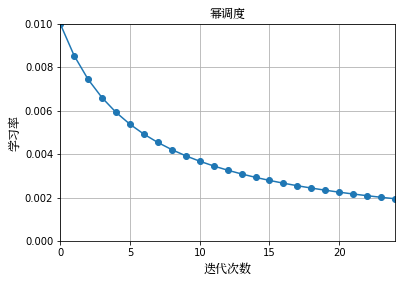

In [83]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train_scaled) / batch_size)  
# ceil()向上取整计算 ceil(55000/32) = 1719
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("迭代次数", font_properties=my_font)
plt.ylabel("学习率", font_properties=my_font)
plt.title("幂调度", font_properties=my_font)
plt.grid(True)
plt.show()

### 指数调度 Exponential Scheduling

> $$
\alpha_t = \alpha_0 0.1^{\frac{t}{s}}
$$

学习率每$s$步将降低10倍.

In [84]:
def exponential_scheduling(lr0, s):
    def function(epoch):
        return lr0*0.1**(epoch/s)
    return function   # 返回配置函数

exponential_scheduling_fn = exponential_scheduling(lr0=0.01, s=20)

In [85]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),
    keras.layers.Dense(100, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),  
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [86]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer='nadam',
              metrics=[keras.metrics.sparse_categorical_accuracy])

`LearningRateScheduler()`回调函数将在每个轮次开始时,更新优化器的`learning_rate`属性.

In [87]:
n_epochs = 25
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_scheduling_fn)
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8590 - sparse_categorical_accuracy: 0.7541 - val_loss: 1.1497 - val_sparse_categorical_accuracy: 0.7246
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6984 - sparse_categorical_accuracy: 0.7909 - val_loss: 0.6128 - val_sparse_categorical_accuracy: 0.7986
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5700 - sparse_categorical_accuracy: 0.8229 - val_loss: 0.7693 - val_sparse_categorical_accuracy: 0.7746
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5318 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.5328 - val_sparse_categorical_accuracy: 0.8372
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4969 - sparse_categorical_accuracy: 0.8443 - val_loss: 0.4721 - val_sparse_categorical_accuracy: 0.8464
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4397 - spars

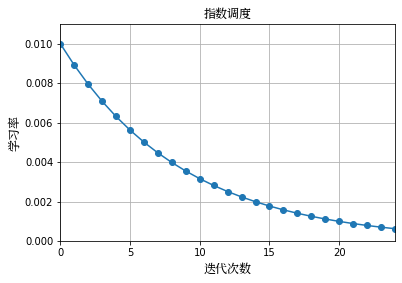

In [88]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("迭代次数", font_properties=my_font)
plt.ylabel("学习率", font_properties=my_font)
plt.title("指数调度", font_properties=my_font)
plt.grid(True)
plt.show()

In [89]:
exponential_scheduling_fn 

<function __main__.exponential_scheduling.<locals>.function(epoch)>

### 分段恒定调度 Piecewise Constant Scheduling

对一些轮次使用恒定的学习率，对于另一些轮次使用较小的学习率,以此类推.尽管这个方法可以很好地工作，但是需要仔细研究以找出正确学习率顺序以及使用他们的轮次.

In [90]:
# def piecewise_constant(epoch):
#     if epoch < 5:
#         return 1e-2
#     elif epoch < 15:
#         return 5e-3
#     else:
#         return 1e-3

In [91]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [92]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),
    keras.layers.Dense(100, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),  
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [93]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer='nadam',
              metrics=[keras.metrics.sparse_categorical_accuracy])

In [94]:
n_epochs = 25
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8789 - sparse_categorical_accuracy: 0.7487 - val_loss: 0.8763 - val_sparse_categorical_accuracy: 0.7546
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9534 - sparse_categorical_accuracy: 0.7106 - val_loss: 1.3367 - val_sparse_categorical_accuracy: 0.6656
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0406 - sparse_categorical_accuracy: 0.6481 - val_loss: 1.5227 - val_sparse_categorical_accuracy: 0.5452
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.1165 - sparse_categorical_accuracy: 0.5987 - val_loss: 1.1534 - val_sparse_categorical_accuracy: 0.5740
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 1.2092 - sparse_categorical_accuracy: 0.5765 - val_loss: 1.1306 - val_sparse_categorical_accuracy: 0.5712
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9270 - spars

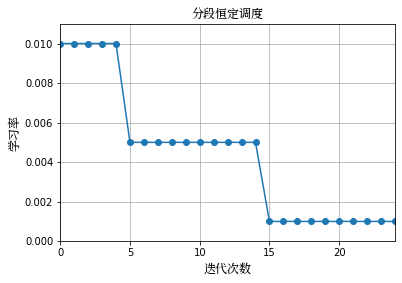

In [95]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("迭代次数", font_properties=my_font)
plt.ylabel("学习率", font_properties=my_font)
plt.title("分段恒定调度", font_properties=my_font)
plt.grid(True)
plt.show()

### 性能调度  Performance Scheduling

每N步检测一次验证误差,并且当误差停止下降时,将学习率降低$\lambda$倍.

In [96]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),
    keras.layers.Dense(100, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),  
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [97]:
optimize = keras.optimizers.SGD(learning_rate=2e-2, momentum=0.9)
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimize,
              metrics=[keras.metrics.sparse_categorical_accuracy])

性能调度使用`ReduceLROnPlateau()`回调函数. 

例:每当连续五个轮次的最好验证损失都没有改善时，将使学习率乘以0.5.

In [98]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

n_epochs = 25
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6066 - sparse_categorical_accuracy: 0.8043 - val_loss: 0.4312 - val_sparse_categorical_accuracy: 0.8554
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4921 - sparse_categorical_accuracy: 0.8390 - val_loss: 0.5610 - val_sparse_categorical_accuracy: 0.8384
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5068 - sparse_categorical_accuracy: 0.8429 - val_loss: 0.5433 - val_sparse_categorical_accuracy: 0.8518
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5115 - sparse_categorical_accuracy: 0.8459 - val_loss: 0.5185 - val_sparse_categorical_accuracy: 0.8540
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5303 - sparse_categorical_accuracy: 0.8481 - val_loss: 0.5311 - val_sparse_categorical_accuracy: 0.8372
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5030 - spars

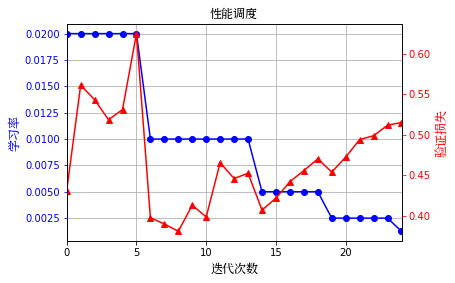

In [99]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("迭代次数", font_properties=my_font)
plt.ylabel("学习率", font_properties=my_font, color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('验证损失', color='r', font_properties=my_font)
ax2.tick_params('y', colors='r')

plt.title("性能调度", font_properties=my_font)
plt.show()

### tf.keras schedulers

使用`keras.optimizers.schedules`中的调度来定义学习率.此方法在**每个步骤更新学习率**,而不是每个轮次.

In [100]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),
    keras.layers.Dense(100, activation=keras.activations.selu,
                       kernel_initializer = keras.initializers.lecun_normal),  
    keras.layers.Dense(10, activation=keras.activations.softmax)
])

In [101]:
# batch size = 32
n_steps_per_epoch = math.ceil(len(X_train_scaled) / batch_size)  

- 等价于 `exponential_scheduling_fn()`

In [102]:
s = 20 * n_steps_per_epoch  

learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

In [103]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimize,
              metrics=[keras.metrics.sparse_categorical_accuracy])

n_epochs = 25
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4839 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.4013 - val_sparse_categorical_accuracy: 0.8600
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3741 - sparse_categorical_accuracy: 0.8658 - val_loss: 0.3677 - val_sparse_categorical_accuracy: 0.8700
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3378 - sparse_categorical_accuracy: 0.8787 - val_loss: 0.3669 - val_sparse_categorical_accuracy: 0.8746
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3134 - sparse_categorical_accuracy: 0.8871 - val_loss: 0.3451 - val_sparse_categorical_accuracy: 0.8804
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2945 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.3319 - val_sparse_categorical_accuracy: 0.8814
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2783 - spars

- 等价于`piecewise_constant_fn()`

In [104]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],  # 每个步骤 因此是迭代*(每次迭代的步骤数)
    values=[0.01, 0.005, 0.001])

In [105]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=optimize,
              metrics=[keras.metrics.sparse_categorical_accuracy])

n_epochs = 25
history = model.fit(X_train_scaled, y_train,
                    epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.3773 - val_sparse_categorical_accuracy: 0.8890
Epoch 2/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1188 - sparse_categorical_accuracy: 0.9582 - val_loss: 0.3872 - val_sparse_categorical_accuracy: 0.8942
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1126 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.3784 - val_sparse_categorical_accuracy: 0.8942
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.9631 - val_loss: 0.3874 - val_sparse_categorical_accuracy: 0.8922
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1039 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.3920 - val_sparse_categorical_accuracy: 0.8938
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0998 - spars

### 1周期调度 1Cycle scheduling

`1周期调度`:从提高初始学习率$η_0$开始,在训练中途线性增长至$η_1$。然后,它在训练的后半部分将学习率再次线性降低到$η_0$,通过将学习率降低几个数量级(仍然是线性的)来完成最几个轮次。

当使用动量时、我们首先从高动量开始(例如0.95),然后在训练的前半部分将其降低到较低的动量(例如线性降低到0.85),然后在训练的后半 部分将其恢复到最大值(例如0.95),并以该最大值结束最后儿个轮次。

In [106]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [107]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [108]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [109]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)

430/430 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.3794


In [110]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

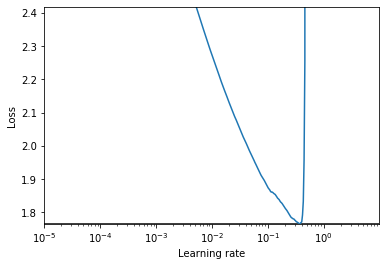

In [111]:
plot_lr_vs_loss(rates, losses)

In [112]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [113]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 1s 3ms/step - loss: 0.6634 - accuracy: 0.7697 - val_loss: 0.4824 - val_accuracy: 0.8350
Epoch 2/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4582 - accuracy: 0.8397 - val_loss: 0.4270 - val_accuracy: 0.8532
Epoch 3/25
430/430 [==============================] - 1s 2ms/step - loss: 0.4124 - accuracy: 0.8554 - val_loss: 0.4113 - val_accuracy: 0.8580
Epoch 4/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3830 - accuracy: 0.8652 - val_loss: 0.3859 - val_accuracy: 0.8628
Epoch 5/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3621 - accuracy: 0.8721 - val_loss: 0.3718 - val_accuracy: 0.8686
Epoch 6/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3433 - accuracy: 0.8772 - val_loss: 0.3690 - val_accuracy: 0.8716
Epoch 7/25
430/430 [==============================] - 1s 2ms/step - loss: 0.3296 - accuracy: 0.8818 - val_loss: 0.3600 - val_accuracy: 0.8722
Epoch 

## L1 和 L2 正则化 L1 and L2 regularizatio

- 将 $\ell_2$ 正则化应用于Keras层的连接权重 

In [114]:
layer = keras.layers.Dense(100, activation=keras.activations.elu,
                           kernel_initializer=keras.initializers.he_normal,
                           kernel_regularizer=keras.regularizers.l1(0.01))
# kernel_regularizer=keras.regularizers.l1_l2(0.1, 0.01) 将同时使用l1,l2正则化

- 使用相同的正则化函数应用于网络中的所有层, 为了避免重复代码,可以使用`partial`包装函数

In [115]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation=keras.activations.elu,
                           kernel_initializer=keras.initializers.he_normal,
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation=keras.activations.softmax)
])

In [116]:
# 编译模型
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer='nadam',
              metrics=[keras.metrics.sparse_categorical_accuracy])

# 训练模型
history = model.fit(X_train, y_train,
                    epochs=2,
                    validation_data=(X_val, y_val))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 1.5814 - sparse_categorical_accuracy: 0.7782 - val_loss: 1.0153 - val_sparse_categorical_accuracy: 0.7680
Epoch 2/2
1719/1719 [==============================] - 6s 4ms/step - loss: 0.9065 - sparse_categorical_accuracy: 0.7951 - val_loss: 0.8512 - val_sparse_categorical_accuracy: 0.8196


## Dropout

当训练一个深度神经网络时,我们可以随机丢弃一部分神经元(同时丢弃其对应的连接边)来避免过拟合,这种方法称为`丢弃法`.每次选择丢弃的神经元是随机的.最简单的方法是设置一个固定的概率$p$.对每一个神经元都以概率$p$来判定要不要保留.

- 集成学习角度:每做一次丢弃,相当于从原始的网络中采样得到一个子网络.如果一个神经网络有$n$个神经元,那么总共可以采样出$2^n$个子网络.每次迭代都相当于训练一个不同的子网络,这些子网络都共享原始网络的参数.那么,最终的网络可以近似看作集成了指数级个不同网络的组合模型. 

- 贝叶斯学习角度:丢弃法也可以解释为一种贝叶斯学习的近似

实践中,你通常只可能对第一至第三层中的神经元应用`Dropout`.

在训练时,激活神经元的平均数量为原来的$p$倍.而在测试时,所有的神经元都是可以激活的,这会造成训练和测试时网络的输出不一致.为了缓解这个问题,在测试时需要将神经层的输入乘以$p$,也相当于把不同的神经网络做了平均.

In [117]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),              # 丢弃率0.2
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [118]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5742 - accuracy: 0.8037 - val_loss: 0.3745 - val_accuracy: 0.8600
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4230 - accuracy: 0.8467 - val_loss: 0.3485 - val_accuracy: 0.8716


当发现模型过拟合,则可以提高`Dropout`率,相反模型欠拟合,则尝试降低`Dropout`率.

## Alpha Dropout

如果要基于`SELU`对归一化网络进行正则化,则应使用`Alpha Dropout`:保留其输入均值和标准差.

In [119]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

In [120]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6662 - accuracy: 0.7584 - val_loss: 0.5735 - val_accuracy: 0.8440
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5535 - accuracy: 0.7956 - val_loss: 0.5484 - val_accuracy: 0.8484
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5242 - accuracy: 0.8062 - val_loss: 0.4875 - val_accuracy: 0.8608
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5081 - accuracy: 0.8128 - val_loss: 0.4754 - val_accuracy: 0.8648
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4913 - accuracy: 0.8164 - val_loss: 0.4593 - val_accuracy: 0.8602
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4823 - accuracy: 0.8235 - val_loss: 0.4725 - val_accuracy: 0.8628
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4732 - accuracy: 0.8249 - val_loss: 0.4760 - val_accuracy:

## MC Dropout

等待补充!

## 最大范数正则化 Max norm

In [121]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))    # r=1 限制最大值约束

In [122]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])

In [123]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_val_scaled, y_val))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4766 - accuracy: 0.8341 - val_loss: 0.3802 - val_accuracy: 0.8636
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3532 - accuracy: 0.8721 - val_loss: 0.3728 - val_accuracy: 0.8664


# 总结和使用指南

- 默认DNN配置

|  超参数   | 默认值  | 
|  :----  | :----  |
| 内核初始化  | He初始化 |
| 激活函数  | ELU |
| 归一化  | 浅层网络:不需要;深度网络:批量归一化 |
| 正则化  | 提前停止(如果需要,可加l2) |
| 优化器  | 动量优化(或 Rmsprop或 Nadam) |
| 学习率调度  | 1周期 |

- 用于自归一化网终的DNN配置

|  超参数   | 默认值  | 
|  :----  | :----  |
| 内核初始化  | LeCun初始化 |
| 激活函数  | SELU |
| 归一化  | 不需要(自规一化) |
| 正则化  | 如果需要: Alpha dropout |
| 优化器  | 动量优化(或 Rmsprop或 Nadam) |
| 学习率调度  | 1周期 |

不要忘了归一化输入特征!你如果可以找到解决类似问题的神经回络、那应该尝试`重用`部分神经网络;如果有大量未标记的数据,则应使用`无监督预训练`:如果有相似任务的大量标记的数据,则应该在`辅助任务上使用预训练`。 

虽然先前的指南应该能涌盖大多数情况,但以下是一些例外情况:
- 如果你需要稀疏模型,则可以使用$ℓ_1$正则化(可以选择在训练后将很小的权重归零)。如果你需要更稀疏的模型,则可以使用 Tensorflow模型优化工具包。这会破 坏自归一化,因此在这种情况下,你应使用默认配置.
- 如果你需要低延迟的模型(执行闪电般快速预测的模型),则可能需要使用更少的层,将批量归一化层融合到先前的层中,并使用更快的激活函数,例如 `leaky RELU` 或仅仅使用`ReLU`。拥有稀硫模型也将有所帮助。最后、你可能想把浮点精度从32位降低到16位甚至8位。再一次检査 TFMOT。
- 如果你要构建风险敏感的应用,或者推理延迟在你的应用中不是很重要,则可以使用 `MC Dropout` 来提高性能并获得更可靠的概率估计以及不确定性估计。


> Apotosome 10/07/21